# Non linear feature extraction of the stratosphere

## Set-up: 

### Imports:

In [90]:
from scipy.spatial import distance_matrix
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from tqdm import tqdm
from time import sleep
import warnings
from sklearn.neighbors import NearestNeighbors
import scipy.sparse.linalg as linalg
import scipy.signal as signal
import seaborn as sns
import matplotlib.dates as mdates
from datetime import datetime
import os

warnings.filterwarnings('ignore')
%load_ext jupyternotify

The jupyternotify extension is already loaded. To reload it, use:
  %reload_ext jupyternotify


### Constants:

In [91]:
# Percentage of nearest neighbours:
PERC_NEIGH = 10
print(f'Percentage of nearest neighbours: {PERC_NEIGH/100}')

# Number of eigenmaps to compute:
NUM_EIGENVALUES = 21
print(f'Number of eigenmaps: {NUM_EIGENVALUES}')

# Data set to consider: ('raw/anomalies')
DATA = 'raw'
print(f'Data set considered: {DATA}')

# Path to input data:
INPUT_DATA = '../../../data/vandermeer/input_data/'
print(f'Path to input data: {INPUT_DATA}')

Percentage of nearest neighbours: 0.1
Number of eigenmaps: 21
Data set considered: raw
Path to input data: ../../../data/vandermeer/input_data/


### Paths:

In [92]:
if DATA == 'raw':
    PATH = '../../../data/vandermeer/pickles/raw/'
elif DATA == 'anomalies': 
    PATH = '../../../data/vandermeer/pickles/anomalies/'
if not os.path.exists(PATH):
        os.makedirs(PATH)
print(f'Global path: {PATH}')

Global path: ../../../data/vandermeer/pickles/raw/


In [93]:
PATH1 = PATH + str(PERC_NEIGH)+'perc/'
if not os.path.exists(PATH1):
        os.makedirs(PATH1)
print(f'Precise path: {PATH1}')

Precise path: ../../../data/vandermeer/pickles/raw/10perc/


In [94]:
# path to simple_kernel:
PATH_SIMPLE = PATH1 + 'simple_kernel/'
if not os.path.exists(PATH_SIMPLE):
        os.makedirs(PATH_SIMPLE)
print(f'Path to simple kernel: {PATH_SIMPLE}')

Path to simple kernel: ../../../data/vandermeer/pickles/raw/10perc/simple_kernel/


### Load data:

In [37]:
%%time
anomalies_cf = pd.read_csv(INPUT_DATA + 'anomalies_coefficients.csv', sep=',')
raw_cf = pd.read_csv(INPUT_DATA + 'raw_data_coefficients.csv', sep=',')
basis_cf = pd.read_csv(INPUT_DATA + 'basis_functions.csv', sep=',')

if DATA == 'raw':
    df = raw_cf
elif DATA == 'anomalies': 
    df = anomalies_cf
df = df.drop(['Unnamed: 0','Date'], axis = 1)
print('Sample of data:')
print(f'Shape of {DATA} data: {df.shape}')
pd.DataFrame(df).head(3)

Sample of data:
Shape of raw data: (33960, 1001)
CPU times: user 22.2 s, sys: 2.64 s, total: 24.9 s
Wall time: 24.8 s


X1        X2        X3        X4        X5        X6        X7  \
0  0.000443  0.000059  0.000018 -0.000257  0.000027  0.000018 -0.000047   
1  0.000436  0.000057  0.000017 -0.000250  0.000028  0.000011 -0.000043   
2  0.000434  0.000058  0.000010 -0.000249  0.000034  0.000009 -0.000043   

         X8        X9       X10  ...          X992          X993  \
0 -0.000025  0.000042  0.000041  ...  1.326600e-06 -2.590231e-07   
1 -0.000030  0.000038  0.000038  ...  3.176703e-07 -2.685431e-07   
2 -0.000029  0.000032  0.000035  ...  1.135065e-06 -1.217742e-06   

           X994          X995          X996          X997          X998  \
0  1.111734e-06 -7.988864e-07  4.408012e-08 -1.217306e-08  9.282409e-07   
1  5.769547e-08  6.127967e-07  4.295968e-08 -7.938383e-08  1.063049e-06   
2  1.196999e-07 -2.562468e-07 -6.708924e-08  7.292826e-08  1.581833e-07   

           X999         X1000         X1001  
0 -5.001676e-07 -4.883183e-08  1.128947e-06  
1 -5.364016e-07  7.481122e-07  2.706997e-07  
2 -4.967490e-07 -8.876771e-08 -9.832148e-07  

[3 rows x 1001 columns]

## Laplacian eigenmaps:

Laplacian eigenmap decomposition according to this [paper](https://www2.imm.dtu.dk/projects/manifold/Papers/Laplacian.pdf).

### Distance matrix:
Calculate matrix of distances between all points:

In [ ]:
# Run this to re-compute distance matrix:
"""
%%notify
print(f'Distance matrix for {DATA}')
distance_df = pd.DataFrame(distance_matrix(df.values, df.values),
                           index=df.index,
                           columns=df.index)
distance_df.to_pickle(PATH + 'distance_matrix.pkl')
"""

Read pre-computed distance matrix:

In [7]:
%%time
print(f'Distance matrix read from {PATH1}')
distance_matrix = pd.read_pickle(PATH1+'distance_matrix.pkl').values

#check distance matrix is symmetric:
assert(np.all(distance_matrix.T == distance_matrix))

print(f'Distance matrix shape: {distance_matrix.shape}')
print('Sample of distance matrix:')
pd.DataFrame(distance_matrix).head(3)

Distance matrix read from ../../../data/vandermeer/pickles/raw/10perc/
Distance matrix shape: (33960, 33960)
Sample of distance matrix:
CPU times: user 38.9 s, sys: 6.28 s, total: 45.2 s
Wall time: 45.1 s


0         1         2         3         4         5         6      \
0  0.000000  0.000049  0.000063  0.000071  0.000073  0.000083  0.000092   
1  0.000049  0.000000  0.000048  0.000062  0.000066  0.000072  0.000081   
2  0.000063  0.000048  0.000000  0.000047  0.000055  0.000063  0.000068   

      7         8         9      ...     33950     33951     33952     33953  \
0  0.000101  0.000109  0.000119  ...  0.000292  0.000298  0.000302  0.000306   
1  0.000092  0.000100  0.000109  ...  0.000285  0.000291  0.000295  0.000299   
2  0.000078  0.000088  0.000098  ...  0.000285  0.000292  0.000295  0.000299   

      33954     33955     33956     33957     33958     33959  
0  0.000306  0.000309  0.000308  0.000309  0.000309  0.000312  
1  0.000299  0.000302  0.000300  0.000301  0.000301  0.000304  
2  0.000299  0.000301  0.000300  0.000300  0.000300  0.000303  

[3 rows x 33960 columns]

Image of distance matrix:

CPU times: user 4.31 s, sys: 2.06 s, total: 6.38 s
Wall time: 6.37 s


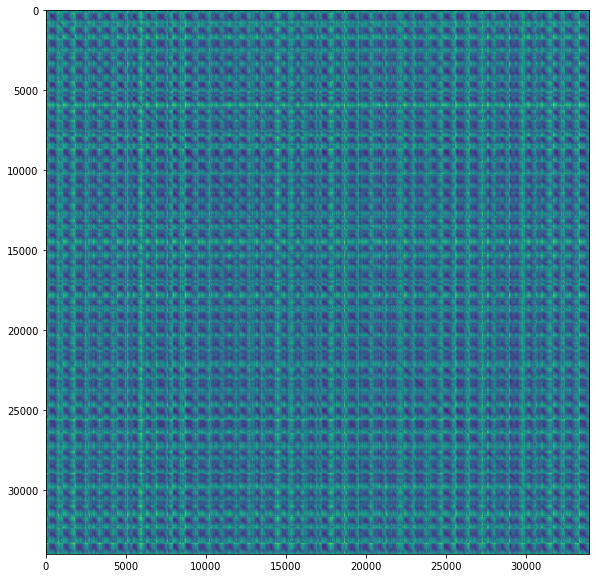

In [8]:
%%time
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(distance_matrix)

### Nearest neighbours:
Calculate matrix with neighbouring vertices, e.g. 1 for $x_j,x_i$ if $x_j$ or $x_i$ selected the other as a closest  neighbour and 0 otherwise. This weight matrix will also serve as the simple kernel. 

In [6]:
df = pd.read_csv(INPUT_DATA + 'raw_data_coefficients.csv', sep=',')

In [9]:
%%time
perc = PERC_NEIGH / 100

if DATA == 'raw':
    df = pd.read_csv(INPUT_DATA + 'raw_data_coefficients.csv', sep=',')
elif DATA == 'anomalies': 
    df = pd.read_csv(INPUT_DATA + 'anomalies_coefficients.csv', sep=',')
print(f'Distance matrix read from {PATH1}')
distance_matrix = pd.read_pickle(PATH1+'distance_matrix.pkl').values

print(f'Look for {perc*100}% nearest neihbours')
K = int(len(df.values) * perc)
N = len(distance_matrix)
weight_matrix = np.zeros((N, N))


for i in tqdm(range(N)):
    # select K closest neihbours
    indices = np.argsort(distance_matrix[i])[:K]
    for j in indices:
        if i != j and weight_matrix[i, j] == 0:
            weight_matrix[i, j] += 1
weight_matrix = weight_matrix.T

# so that matrix is symmetric:
for i in tqdm(range(N)):
    indices = np.argsort(distance_matrix.T[i])[:K]
    for j in indices:
        if i != j and weight_matrix[i, j] == 0:
            weight_matrix[i, j] += 1
weight_df = pd.DataFrame(weight_matrix)

# Save weight matrix:
PATH_SAVE = PATH_SIMPLE+'weight_matrix_{}.pkl'.format(PERC_NEIGH)
print('Saving weight matrix at {}'.format(PATH_SAVE))
weight_df.to_pickle(PATH_SAVE)

del weight_df, weight_matrix, distance_matrix
print('Done')

Distance matrix read from ../../../data/vandermeer/pickles/anomalies/10perc/
Look for 10.0% nearest neihbours


100%|██████████| 33960/33960 [04:41<00:00, 120.64it/s]


Saving weight matrix at ../../../data/vandermeer/pickles/anomalies/10perc/simple_kernel/weight_matrix_10.pkl
Done
CPU times: user 8min 51s, sys: 45.7 s, total: 9min 37s
Wall time: 12min 17s


In [6]:
%%time
# Read weight matrix:
weight_m = pd.read_pickle(PATH_SIMPLE +
                          'weight_matrix_{}.pkl'.format(PERC_NEIGH)).values
# Test if matrix is symetric:
assert (np.all(weight_m.T == weight_m))
print(f'Weight matrix shape: {weight_m.shape}')

Weight matrix shape: (33960, 33960)
CPU times: user 39.4 s, sys: 5.81 s, total: 45.2 s
Wall time: 45.2 s


In [7]:
pd.DataFrame(weight_m).head(5)

0      1      2      3      4      5      6      7      8      9      ...  \
0    0.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0  ...   
1    1.0    0.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0  ...   
2    1.0    1.0    0.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0  ...   
3    1.0    1.0    1.0    0.0    1.0    1.0    1.0    1.0    1.0    1.0  ...   
4    1.0    1.0    1.0    1.0    0.0    1.0    1.0    1.0    1.0    1.0  ...   

   33950  33951  33952  33953  33954  33955  33956  33957  33958  33959  
0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  
1    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  
2    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  
3    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  
4    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  

[5 rows x 33960 columns]

Look at image of weight matrix:

CPU times: user 4.64 s, sys: 8.3 s, total: 12.9 s
Wall time: 13 s


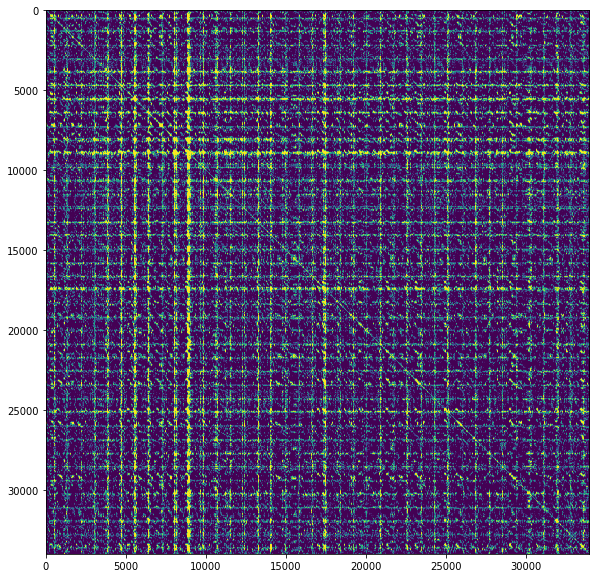

In [8]:
%%time
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(weight_m)
del weight_m

### Simple kernel: 

Diagonal matrix from weight matrix, computed as $D_{ij} = \sum_{j}W_{ij}$

In [10]:
%%time
weight_m = pd.read_pickle(PATH_SIMPLE +
                          'weight_matrix_{}.pkl'.format(PERC_NEIGH)).values
D = np.zeros((len(weight_m), len(weight_m)))

# Test if matrix is symetric:
print('Computing diagonal matrix:')
for i in tqdm(range(len(weight_m))):
    D[i, i] = np.sum(weight_m[i])
D_df = pd.DataFrame(D)

print(f'Saving diagonal matrix at: {PATH_SIMPLE}')
D_df.to_pickle(PATH_SIMPLE+'diagonal_matrix_{}.pkl'.format(PERC_NEIGH))
print('Done!')

  0%|          | 98/33960 [00:00<00:34, 971.14it/s]

Computing diagonal matrix:


100%|██████████| 33960/33960 [00:41<00:00, 821.77it/s]


Saving diagonal matrix at: ../../../data/vandermeer/pickles/anomalies/10perc/simple_kernel/
Done!
CPU times: user 44 s, sys: 18.6 s, total: 1min 2s
Wall time: 1min 30s


Laplacian matrix computed as $L = D-W$

In [11]:
%%time
print('Computing Laplacian matrix:')

L = np.subtract(D, weight_m)
L_df = pd.DataFrame(L)
print(f'Saving laplacian matrix at: {PATH_SIMPLE}')
L_df.to_pickle(PATH_SIMPLE + 'laplacian_simple_matrix_{}.pkl'.format(PERC_NEIGH))

del L, L_df, D, weight_m
print('Done!')

Computing Laplacian matrix:
Saving laplacian matrix at: ../../../data/vandermeer/pickles/anomalies/10perc/simple_kernel/
Done!
CPU times: user 38.7 s, sys: 20.6 s, total: 59.3 s
Wall time: 1min 21s


Eigenvalues and eigenvectors for simple kernel:

In [6]:
%%time
print(f'Reading D and L from: {PATH_SIMPLE}')
D = pd.read_pickle(PATH_SIMPLE +
                   'diagonal_matrix_{}.pkl'.format(PERC_NEIGH)).values
L = pd.read_pickle(PATH_SIMPLE +
                   'laplacian_simple_matrix_{}.pkl'.format(PERC_NEIGH)).values

print(f'Computing {NUM_EIGENVALUES} eigenvalues:')
# compute 20 first eigenvalues
w, eigv = linalg.eigs(L, k=NUM_EIGENVALUES, M=D, which='SM')

# save values:
print(f'Saving eigenvalues and eigenvectors to: {PATH_SIMPLE}')
pd.DataFrame(w).to_pickle(PATH_SIMPLE + 'eigenvalues_{}.pkl'.format(PERC_NEIGH))
pd.DataFrame(eigv).to_pickle(PATH_SIMPLE +
                             'eigenvectors_{}.pkl'.format(PERC_NEIGH))
del L, D, w, eigv
print('Done!')

Reading D and L from: ../../../data/vandermeer/pickles/raw/10perc/simple_kernel/
Computing 21 eigenvalues:
Saving eigenvalues and eigenvectors to: ../../../data/vandermeer/pickles/raw/10perc/simple_kernel/
Done!
CPU times: user 28min 37s, sys: 5min 58s, total: 34min 35s
Wall time: 7min 57s


### Heat kernel: 
The heat kernel is computed as $W_{ij} = exp(\frac{-||x_j-x_i||^2_2}{t})$ for connected neighbours and 0 otherwise.
Source:[paper](https://www2.imm.dtu.dk/projects/manifold/Papers/Laplacian.pdf)

#### Choice of bandwidth: 
Compute the right bandwidth $t$ values for the heat kernel. Try the mean, median and maximum over distances of neihgbouring vertices.

In [15]:
%%time
print(f'Reading distance and weight matrix from: {PATH1}')
distance_matrix = pd.read_pickle(PATH1+'distance_matrix.pkl').values
weight_m = pd.read_pickle(PATH_SIMPLE +'weight_matrix_{}.pkl'.format(PERC_NEIGH)).values

Reading distance and weight matrix from: ../../../data/vandermeer/pickles/anomalies/10perc/
CPU times: user 97.7 ms, sys: 44.1 s, total: 44.2 s
Wall time: 4min 11s


In [16]:
%%time
# Select only distances that are chosen in the nearest neighbours step:
mult_df = np.multiply(distance_matrix, weight_m)
non_zero_mult = np.extract(mult_df > 0, mult_df)

CPU times: user 45.3 s, sys: 9.08 s, total: 54.3 s
Wall time: 54.4 s


In [17]:
# Calculate the mean, median and max over non-zero distances:
mean_distances = np.mean(non_zero_mult)
median_dist = np.median(non_zero_mult)
max_distances = np.max(non_zero_mult)

t = [mean_distances, median_dist, max_distances]

ts = {
    'mean_distances': mean_distances,
    'median_dist': median_dist,
    'max_distances': max_distances,
    'mean_dist_all': np.mean(distance_matrix),
    'max_dist_all': np.max(distance_matrix),
}
np.save(PATH1 + 't.npy', np.array(t))
print(ts)

{'mean_distances': 1.0101172556500304, 'median_dist': 0.9742780424434717, 'max_distances': 2.258806418267848, 'mean_dist_all': 1.3558625173005796, 'max_dist_all': 3.5051516474690554}


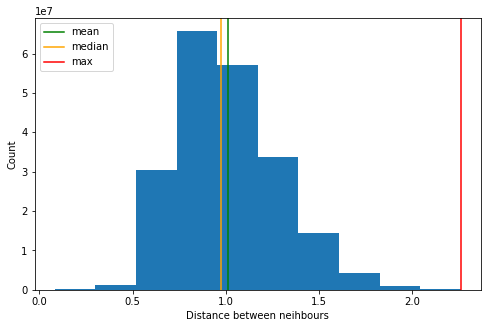

In [18]:
fig = plt.figure(figsize = (8,5))
axs = plt.subplot(1,1,1)
axs.hist(non_zero_mult)
#plt.title('Non zero distances between neighbours:')
axs.axvline(t[0], color = 'green', label = 'mean')
axs.axvline(t[1], color = 'orange', label = 'median')
axs.axvline(t[2], color = 'red', label = 'max')
axs.set_xlabel('Distance between neihbours')
axs.set_ylabel('Count')
plt.legend()

In [21]:
del distance_matrix, weight_m, mult_df, non_zero_mult

#### Heat matrix: 

Computing heat kernels:

In [22]:
%%time
t = np.load(PATH1+'t.npy')
corr_t = ['mean', 'med', 'max']
print(f'Reading distance and weight matrix from: {PATH1}')
distance_matrix = pd.read_pickle(PATH1+'distance_matrix.pkl').values
weight_m = pd.read_pickle(PATH_SIMPLE+'weight_matrix_{}.pkl'.format(PERC_NEIGH)).values

for i in range(3):
    chosen_t = t[i]
    print('Computing heat matrix for bandwitdh {}: {}'.format(corr_t[i],chosen_t))
    
    PATH2 = PATH1+'t_'+corr_t[i]+'/'
    if not os.path.exists(PATH2):
        os.makedirs(PATH2)
        
    distance_df = pd.DataFrame(distance_matrix)
    # Create heat matrix:
    heat_matrix_df = distance_df.apply(lambda x: np.exp(-(x**2) / (chosen_t**2)))
    heat_matrix_df = pd.DataFrame(np.multiply(weight_m, heat_matrix_df))
    heat_matrix_df.to_pickle(PATH2+'heat_matrix_'+'t_'+corr_t[i]+ '_.pkl')
del heat_matrix_df, distance_matrix, weight_m, distance_df

Reading distance and weight matrix from: ../../../data/vandermeer/pickles/anomalies/10perc/
Computing heat matrix for bandwitdh mean: 1.0101172556500304
Computing heat matrix for bandwitdh med: 0.9742780424434717
Computing heat matrix for bandwitdh max: 2.258806418267848
CPU times: user 3min 25s, sys: 1min 40s, total: 5min 6s
Wall time: 5min 58s


Load pre-computed heat kernels for 10% neighbours:

In [6]:
%%time
corr_t = ['mean', 'med', 'max']
PATH_READ = '../../../data/vandermeer/pickles/{}/10perc/'.format(DATA)
print(f'Path to heat matrices:{PATH_READ}')
print(f'Reading heat matrix for t = {corr_t[0]}:')
heat_matrix_mean = pd.read_pickle(PATH_READ +'t_'+corr_t[0]+ '/' +
                                  'heat_matrix_' +'t_'+corr_t[0]+'_.pkl').values
print(f'Reading heat matrix for t = {corr_t[1]}:')
heat_matrix_max = pd.read_pickle(PATH_READ +'t_'+corr_t[1]+ '/' +
                                 'heat_matrix_' +'t_'+corr_t[1]+'_.pkl').values
print(f'Reading heat matrix for t = {corr_t[2]}:')
heat_matrix_med = pd.read_pickle(PATH_READ +'t_'+corr_t[2]+ '/' +
                                 'heat_matrix_' +'t_'+corr_t[2]+'_.pkl').values

Path to heat matrices:../../../data/vandermeer/pickles/anomalies/10perc/
Reading heat matrix for t = mean:
Reading heat matrix for t = med:
Reading heat matrix for t = max:
CPU times: user 99.9 ms, sys: 37.5 s, total: 37.6 s
Wall time: 1min 23s


Load pre-computed heat kernels for 20% neighbours:

In [7]:
%%time
corr_t = ['mean', 'med', 'max']
PATH_READ = '../../../data/vandermeer/pickles/{}/20perc/'.format(DATA)
print(f'Path to heat matrices:{PATH_READ}')
print(f'Reading heat matrix for t = {corr_t[0]}:')
heat_matrix_mean2 = pd.read_pickle(PATH_READ +'t_'+corr_t[0]+ '/' +
                                  'heat_matrix_' +'t_'+corr_t[0]+
                                  '_.pkl').values
print(f'Reading heat matrix for t = {corr_t[1]}:')
heat_matrix_max2 = pd.read_pickle(PATH_READ +'t_'+corr_t[1]+ '/' +
                                 'heat_matrix_' +'t_'+corr_t[1]+
                                 '_.pkl').values
print(f'Reading heat matrix for t = {corr_t[2]}:')
heat_matrix_med2 = pd.read_pickle(PATH_READ +'t_'+corr_t[2]+ '/' +
                                 'heat_matrix_' +'t_'+corr_t[2]+
                                 '_.pkl').values

Path to heat matrices:../../../data/vandermeer/pickles/anomalies/20perc/
Reading heat matrix for t = mean:
Reading heat matrix for t = med:
Reading heat matrix for t = max:
CPU times: user 9.32 ms, sys: 41.5 s, total: 41.5 s
Wall time: 1min 4s


In [8]:
#Check matrices not the same:
assert(np.all(heat_matrix_mean == heat_matrix_mean2)==False)

Plot sample of heat kernels as image:

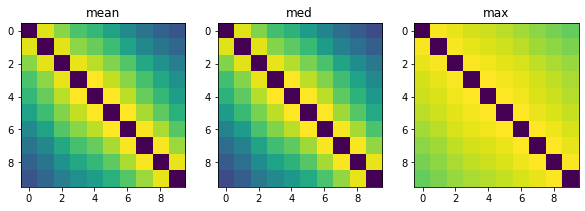

In [9]:
fig, axs = plt.subplots(1, 3, figsize=(10, 10))
i = 0
corr_t = ['mean', 'med', 'max']
matrices = [heat_matrix_mean[:10, :10],heat_matrix_max[:10, :10],heat_matrix_med[:10, :10]]
for chosen_t in corr_t:
    axs[i].imshow(matrices[i])
    axs[i].set_title(chosen_t)
    i += 1

Plot histogram of non zero values of heat kernels:

CPU times: user 3min 30s, sys: 27.6 s, total: 3min 57s
Wall time: 3min 57s


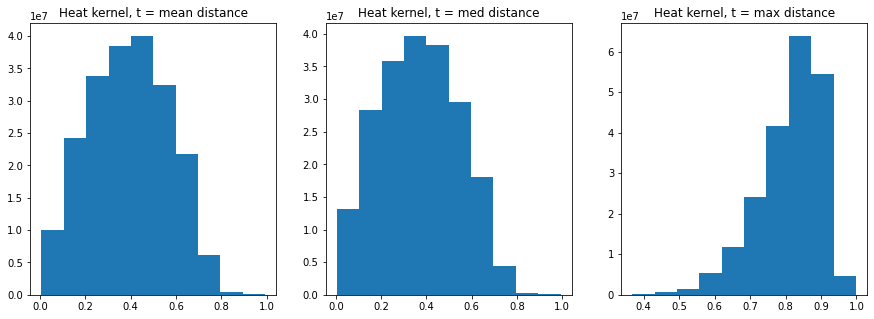

In [10]:
%%time
fig, axs = plt.subplots(1,3, figsize = (15,5))
i = 0
corr_t = ['mean', 'med', 'max']
matrices = [heat_matrix_mean, heat_matrix_max, heat_matrix_med]
for i in range(3):
    heat_matrix = matrices[i]
    non_zero_heat = np.extract(heat_matrix>0, heat_matrix)
    axs[i].set_title('Heat kernel, t = {} distance'.format(corr_t[i]))
    axs[i].hist(non_zero_heat, label = '10 perc')
    i+=1

Plot overlapping histogram of non zero values of heat kernels for 10% and 20%:

CPU times: user 6min 44s, sys: 30.1 s, total: 7min 14s
Wall time: 7min 15s


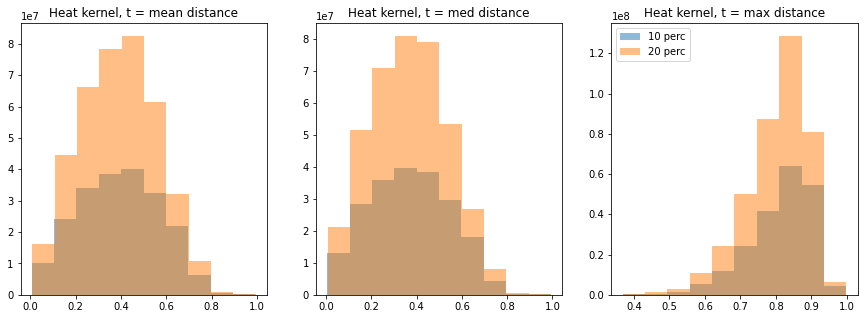

In [11]:
%%time
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
i = 0
matrices = [heat_matrix_mean, heat_matrix_max, heat_matrix_med]
matrices2 = [heat_matrix_mean2, heat_matrix_max2, heat_matrix_med2]
corr_t = ['mean', 'med', 'max']
for i in range(3):
    heat_matrix = matrices[i]
    heat_matrix2 = matrices2[i]
    non_zero_heat = np.extract(heat_matrix > 0, heat_matrix)
    non_zero_heat2 = np.extract(heat_matrix2 > 0, heat_matrix2)
    t = ['mean', 'max', 'median']
    axs[i].set_title('Heat kernel, t = {} distance'.format(corr_t[i]))
    axs[i].hist(non_zero_heat, label='10 perc', alpha=0.5)
    axs[i].hist(non_zero_heat2, label='20 perc', alpha=0.5)
    i += 1
plt.legend()
del matrices, matrices2, heat_matrix_mean, heat_matrix_max, heat_matrix_med, heat_matrix_mean2, heat_matrix_max2, heat_matrix_med2

#### Diagonal weight matrix: 
Compute diagonal matrix as $D_{ii} = \sum_j W_{ij}$

In [222]:
corr_t = ['mean', 'med', 'max']
for j in range(3):
    print(f'Computing diagonal matrix for heat kernel with t: {corr_t[j]}')
    PATH2 = PATH1+'t_'+corr_t[j]+'/'
    if not os.path.exists(PATH2):
        os.makedirs(PATH2)
    wm = pd.read_pickle(PATH1+'t_'+corr_t[j]+'/heat_matrix_t_'+corr_t[j]+'_.pkl').values
    D = np.zeros((len(wm),len(wm)))
    for i in tqdm(range(len(wm))):
        D[i,i] = np.sum(wm[i])
    D_df = pd.DataFrame(D)
    D_df.to_pickle(PATH2+'diagonal_heat_matrix_t_'+corr_t[j]+'_.pkl')
del D_df, D, wm

Computing diagonal matrix for heat kernel with t: mean


100%|██████████| 33960/33960 [00:48<00:00, 694.73it/s]


Computing diagonal matrix for heat kernel with t: med


100%|██████████| 33960/33960 [00:39<00:00, 858.12it/s]


Computing diagonal matrix for heat kernel with t: max


100%|██████████| 33960/33960 [00:42<00:00, 805.95it/s]


Load pre-computed diagonal matrix_:

In [8]:
%%time
D = pd.read_pickle(PATH1+'t_mean/diagonal_heat_matrix_'+'t_mean_.pkl').values
print(f'Shape of diagonal matrix: {D.shape}')
pd.DataFrame(D).head(5)

Shape of diagonal matrix: (33960, 33960)
CPU times: user 9.48 ms, sys: 15.7 s, total: 15.7 s
Wall time: 36.1 s


0           1           2           3           4      5      6      \
0  344.187062    0.000000    0.000000    0.000000    0.000000    0.0    0.0   
1    0.000000  373.615446    0.000000    0.000000    0.000000    0.0    0.0   
2    0.000000    0.000000  365.289534    0.000000    0.000000    0.0    0.0   
3    0.000000    0.000000    0.000000  368.326306    0.000000    0.0    0.0   
4    0.000000    0.000000    0.000000    0.000000  383.301596    0.0    0.0   

   7      8      9      ...  33950  33951  33952  33953  33954  33955  33956  \
0    0.0    0.0    0.0  ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
1    0.0    0.0    0.0  ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
2    0.0    0.0    0.0  ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
3    0.0    0.0    0.0  ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
4    0.0    0.0    0.0  ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0   

   33957  33958  33959  
0    0.0    0.0    0.0  
1    0.0    0.0    0.0  
2    0.0    0.0    0.0  
3    0.0    0.0    0.0  
4    0.0    0.0    0.0  

[5 rows x 33960 columns]

In [9]:
del D

#### Laplacian matrix: 

Compute Laplacian matrix as $L = D- W$

In [12]:
%%time
corr_t = ['mean', 'med', 'max']
for j in range(3):
    print(f'Computing Laplacian matrix for heat kernel with t: {corr_t[j]}')
    PATH2 = PATH1 + 't_' + corr_t[j] + '/'
    if not os.path.exists(PATH2):
        os.makedirs(PATH2)
    print('Reading heat matrix:')
    wm = pd.read_pickle(PATH2+'heat_matrix_t_'+corr_t[j]+'_.pkl').values
    print('Reading diagonal matrix:')
    D = pd.read_pickle(PATH2+'diagonal_heat_matrix_t_'+corr_t[j]+'_.pkl').values
    print('Calculating Laplacian:')
    L = np.subtract(D, wm)
    L_df = pd.DataFrame(L)
    L_df.to_pickle(PATH2+'laplacian_heat_matrix_t_'+corr_t[j]+'_.pkl')
del L_df, L, D, wm
print('Done!')

Computing Laplacian matrix for heat kernel with t: mean
Reading heat matrix:
Computing Laplacian matrix for heat kernel with t: med
Reading heat matrix:
Reading diagonal matrix:
Calculating Laplacian:
Computing Laplacian matrix for heat kernel with t: max
Reading heat matrix:
Reading diagonal matrix:
Calculating Laplacian:
Done!
CPU times: user 2min 10s, sys: 2min 27s, total: 4min 37s
Wall time: 11min 33s


Load pre-computed laplacian matrix:

In [13]:
%%time
PATH2 = PATH1 + 't_mean/'
L = pd.read_pickle(PATH2+'laplacian_heat_matrix_t_mean_.pkl').values
print(f'Shape of Laplacian matrix: {L.shape}')
pd.DataFrame(L).head(5)

Shape of Laplacian matrix: (33960, 33960)
CPU times: user 59.2 ms, sys: 14.3 s, total: 14.4 s
Wall time: 1min 32s


0           1           2           3           4         5      \
0  344.187062   -0.846666   -0.731896   -0.635934   -0.592692 -0.511058   
1   -0.846666  373.615446   -0.852548   -0.735488   -0.681364 -0.614088   
2   -0.731896   -0.852548  365.289534   -0.860316   -0.797494 -0.721679   
3   -0.635934   -0.735488   -0.860316  368.326306   -0.886954 -0.806626   
4   -0.592692   -0.681364   -0.797494   -0.886954  383.301596 -0.888373   

      6         7         8         9      ...  33950  33951  33952  33953  \
0 -0.423440 -0.341226 -0.280494 -0.229948  ...    0.0    0.0    0.0    0.0   
1 -0.510554 -0.414019 -0.346640 -0.292857  ...    0.0    0.0    0.0    0.0   
2 -0.649261 -0.537476 -0.452664 -0.380244  ...    0.0    0.0    0.0    0.0   
3 -0.731934 -0.631219 -0.535008 -0.445793  ...    0.0    0.0    0.0    0.0   
4 -0.800926 -0.680735 -0.592418 -0.494022  ...    0.0    0.0    0.0    0.0   

   33954  33955  33956  33957  33958  33959  
0    0.0    0.0    0.0    0.0    0.0    0.0  
1    0.0    0.0    0.0    0.0    0.0    0.0  
2    0.0    0.0    0.0    0.0    0.0    0.0  
3    0.0    0.0    0.0    0.0    0.0    0.0  
4    0.0    0.0    0.0    0.0    0.0    0.0  

[5 rows x 33960 columns]

In [14]:
del L

#### Eigenvalues: 

Eigendecomposition of: $Lf = \gamma Df$ where $f$ are the eigenvector solutions ordered according to their increasing eigenvalue $\lambda_0 = 0 < \lambda_1 < ...$

Computing eigendecomposition:

In [23]:
%%time
chosen_t = 'mean'
print(f'Computing eigenvalues for heat kernel with t={chosen_t}')

PATH2 = PATH1+'t_{}/'.format(chosen_t)
if not os.path.exists(PATH2):os.makedirs(PATH2)

print(f'Loading L from:{PATH2}')   
L = pd.read_pickle(PATH2+'laplacian_heat_matrix_t_'+chosen_t+'_.pkl').values

print(f'Loading D from:{PATH2}')   
D = pd.read_pickle(PATH2+'diagonal_heat_matrix_t_'+chosen_t+'_.pkl').values

print(f'Computing {NUM_EIGENVALUES} eigenvalues:')
w, eigv = linalg.eigs(L, k=NUM_EIGENVALUES, M=D, which='SM')

print('Saving eigendecomposition:')
pd.DataFrame(w).to_pickle(PATH2 + 'eigenvalues_heat_matrix_t_'+chosen_t+'_.pkl')
pd.DataFrame(eigv).to_pickle(PATH2 + 'eigenvectors_heat_matrix_t_'+chosen_t+ '_.pkl')

del L, D, w, eigv

Computing eigenvalues for heat kernel with t=mean
Loading L from:../../../data/vandermeer/pickles/anomalies/10perc/t_mean/
Loading D from:../../../data/vandermeer/pickles/anomalies/10perc/t_mean/
Computing 21 eigenvalues:
Saving eigendecomposition:
CPU times: user 30min 41s, sys: 6min 27s, total: 37min 9s
Wall time: 6min 5s


## Plot eigenmaps:

### Create time-series:

Loading eigendecomposition for heat kernel:

In [95]:
chosen_t = 'mean'
print(f'Loading eigendecomposition for t={chosen_t} at {PATH1}')
w_mean = pd.read_pickle(PATH1+'t_'+chosen_t+'/eigenvalues_heat_matrix_t_'+chosen_t+'_.pkl')
eigv_mean = pd.read_pickle(PATH1+'t_'+chosen_t+'/eigenvectors_heat_matrix_t_'+chosen_t+'_.pkl')

Loading eigendecomposition for t=mean at ../../../data/vandermeer/pickles/raw/10perc/


In [96]:
if DATA == 'raw':
    # weirdly 0 in position 1 so invert position 0 and 1
    w_mean[0][1] = w_mean[0][0]
    w_mean[0][0] = 0

Loading eigendecomposition for simple kernel:

In [97]:
print(f'Loading eigendecomposition for simple kernel at {PATH_SIMPLE}')
w_simple = pd.read_pickle(PATH_SIMPLE+'eigenvalues_{}.pkl'.format(PERC_NEIGH))
eigv_simple = pd.read_pickle(PATH_SIMPLE+ 'eigenvectors_{}.pkl'.format(PERC_NEIGH))

Loading eigendecomposition for simple kernel at ../../../data/vandermeer/pickles/raw/10perc/simple_kernel/


In [98]:
if DATA == 'raw':
    # weirdly 0 in position 1 so invert position 0 and 1
    w_simple[0][1] = w_simple[0][0]
    w_simple[0][0] = 0

Get time component for time-series

In [99]:
%%time
if DATA == 'anomalies':
    df = pd.read_csv(INPUT_DATA + 'anomalies_coefficients.csv', sep=',')
else:
    df = pd.read_csv(INPUT_DATA + 'raw_data_coefficients.csv', sep=',')
time = df['Date']
time = pd.to_datetime(time)
del df

CPU times: user 8.54 s, sys: 403 ms, total: 8.94 s
Wall time: 8.94 s


Create time-series for both types of eigenvectors:

In [100]:
eigv_time_mean = pd.concat([time, pd.DataFrame(eigv_mean)], axis=1)
eigv_time_mean = eigv_time_mean.set_index('Date')
if DATA == 'raw':
    eigv_time_mean = eigv_time_mean.drop([1], axis=1)
else:
    eigv_time_mean = eigv_time_mean.drop([0], axis=1)
eigv_time_mean.columns = range(1, NUM_EIGENVALUES)

In [101]:
eigv_time_simple = pd.concat([time, pd.DataFrame(eigv_simple)], axis=1)
eigv_time_simple = eigv_time_simple.set_index('Date')
if DATA == 'raw':
    eigv_time_simple = eigv_time_simple.drop([1], axis=1)
else:
    eigv_time_simple = eigv_time_simple.drop([0], axis=1)
eigv_time_simple.columns = range(1, NUM_EIGENVALUES)

### Plot eigenvalues:

In [26]:
def plot_eigenvalues(w_mean, w_simple, NUM_EIGENVALUES):
    fig, axs = plt.subplots(1, figsize=(10, 5))
    axs.scatter(x=range(0, NUM_EIGENVALUES),
                y=w_mean,
                marker='o',
                alpha=0.7,
                label='heat kernel')
    axs.scatter(x=range(0, NUM_EIGENVALUES),
                y=w_simple,
                marker='o',
                alpha=0.7,
                label='simple simple')
    #axs.set_title(f'Eigenvalues for heat and simple kernel')
    axs.set_ylabel('Eigenvalues')
    axs.set_xlabel('Number of eigenvalue')
    plt.locator_params(axis='x', nbins=21)
    axs.legend()

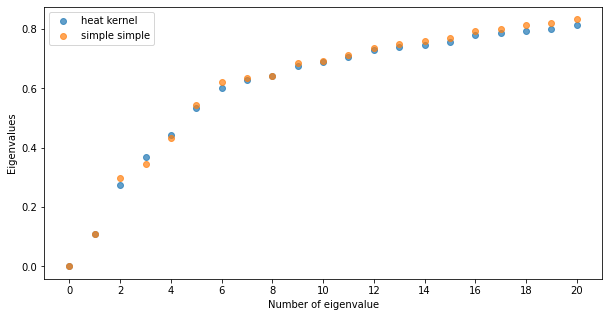

In [27]:
plot_eigenvalues(w_mean, w_simple, NUM_EIGENVALUES)

### Plot all eigenvectors for all years:

In [28]:
def plot_all_eig(eigv_time, eigv_time_simple):
    fig, axs = plt.subplots(5, 2, figsize=(20, 20))
    m = 1
    for i in range(2):
        for j in range(5):
            axs[j, i].scatter(eigv_time[m].index,
                              eigv_time[m].values,
                              marker='.', label = 'Heat kernel')
            axs[j, i].scatter(eigv_time_simple[m].index,
                              eigv_time_simple[m].values,
                              marker='.', label = 'Simple kernel')
            axs[j, i].set_title(f"eigenvector {m}")
            m += 1
    plt.legend(loc = 'upper right')

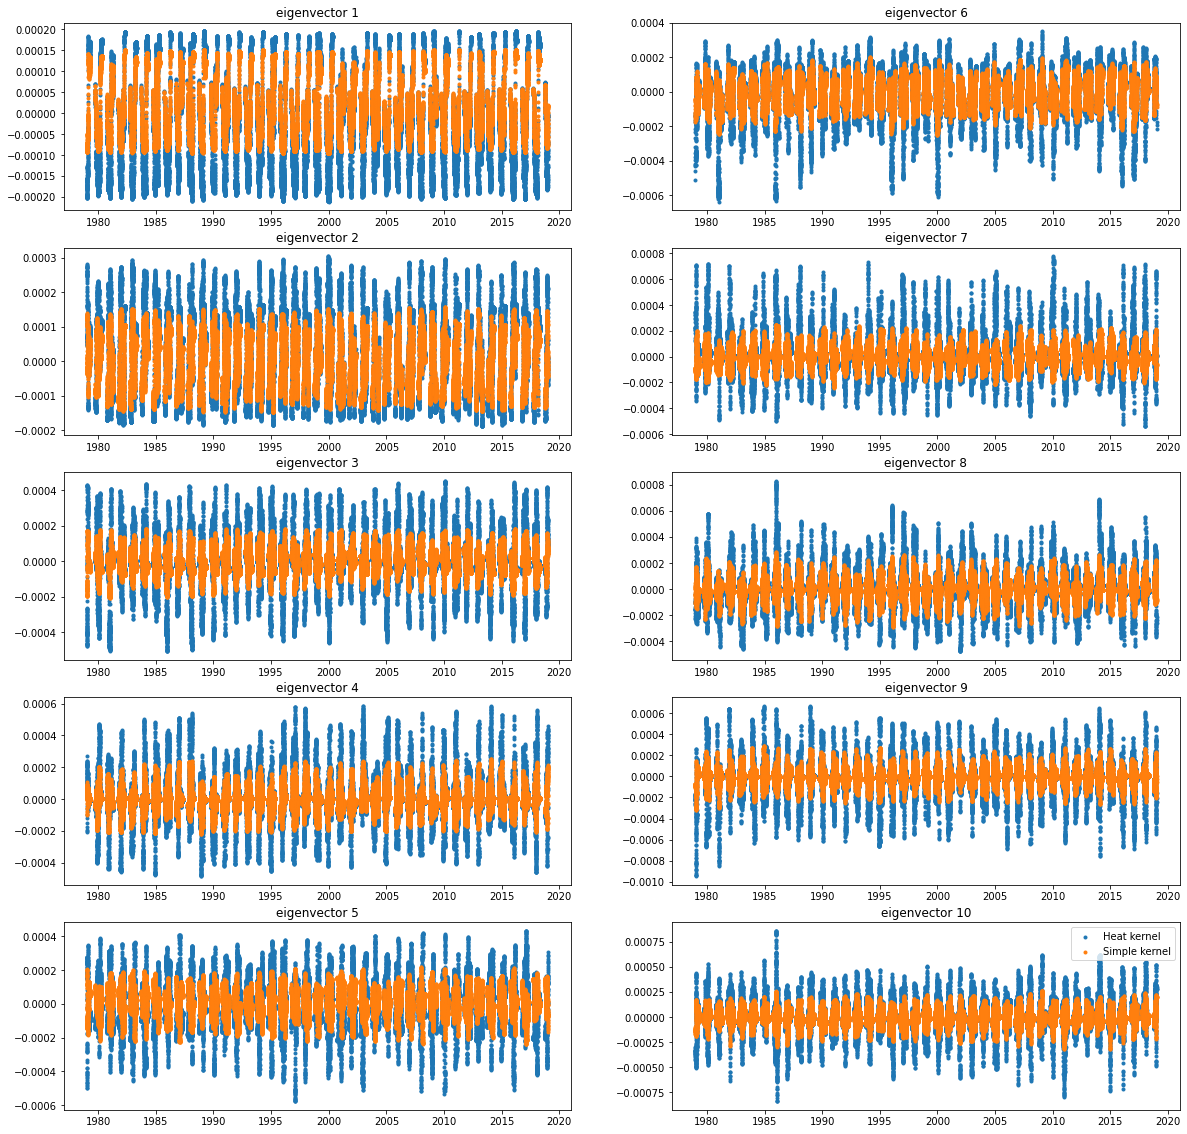

In [29]:
plot_all_eig(eigv_time_mean, eigv_time_simple)

### Norm of eigenvectors:

Check order of eigenvectors. Try $y^T D y = 1$

In [18]:
chosen_t = 'mean'
PATH2 = PATH1+'t_{}/'.format(chosen_t)
print(f'Read diagonal matrix at {PATH2}')
D = pd.read_pickle(PATH2+'diagonal_heat_matrix_t_{}_.pkl'.format(chosen_t)).values

Read diagonal matrix at ../../../data/vandermeer/pickles/raw/10perc/t_mean/


KeyboardInterrupt: 

In [ ]:
for i in eigv_time_mean.columns:
    y = eigv_time_mean[i]
    norm = y.T@D@y
    print(f'Eigenvector {i} has norm {norm}')
del D

### Plot one winter (2008-2009):

In [30]:
def plot_one_winter(eigv_time, eigv_time_simple, sign_mean, sign_simple):
    fig, axs = plt.subplots(4, 5, figsize=(23, 20))
    m = 1
    for i in range(4):
        for j in range(5):
            winter_2008 = pd.date_range('2008-11', '2009-04')
            winter_2008_eig_mean = eigv_time[m][winter_2008]
            winter_2008_eig_simple = eigv_time_simple[m][winter_2008]

            axs[i, j].plot(winter_2008_eig_mean.index,
                           sign_mean[m] * winter_2008_eig_mean.values,
                           label='heat kernel')
            axs[i, j].plot(winter_2008_eig_simple.index,
                           sign_simple[m] * winter_2008_eig_simple.values,
                           label='simple')
            axs[i, j].set_title(f"Eigenvector {m}")
            axs[i, j].set_xticklabels(['Nov', 'Dec', 'Jan', 'Feb', 'Mar', 'Ap'])
            m += 1
    plt.legend()
    #plt.suptitle('Eigenvectors for one winter of 2008-2009')

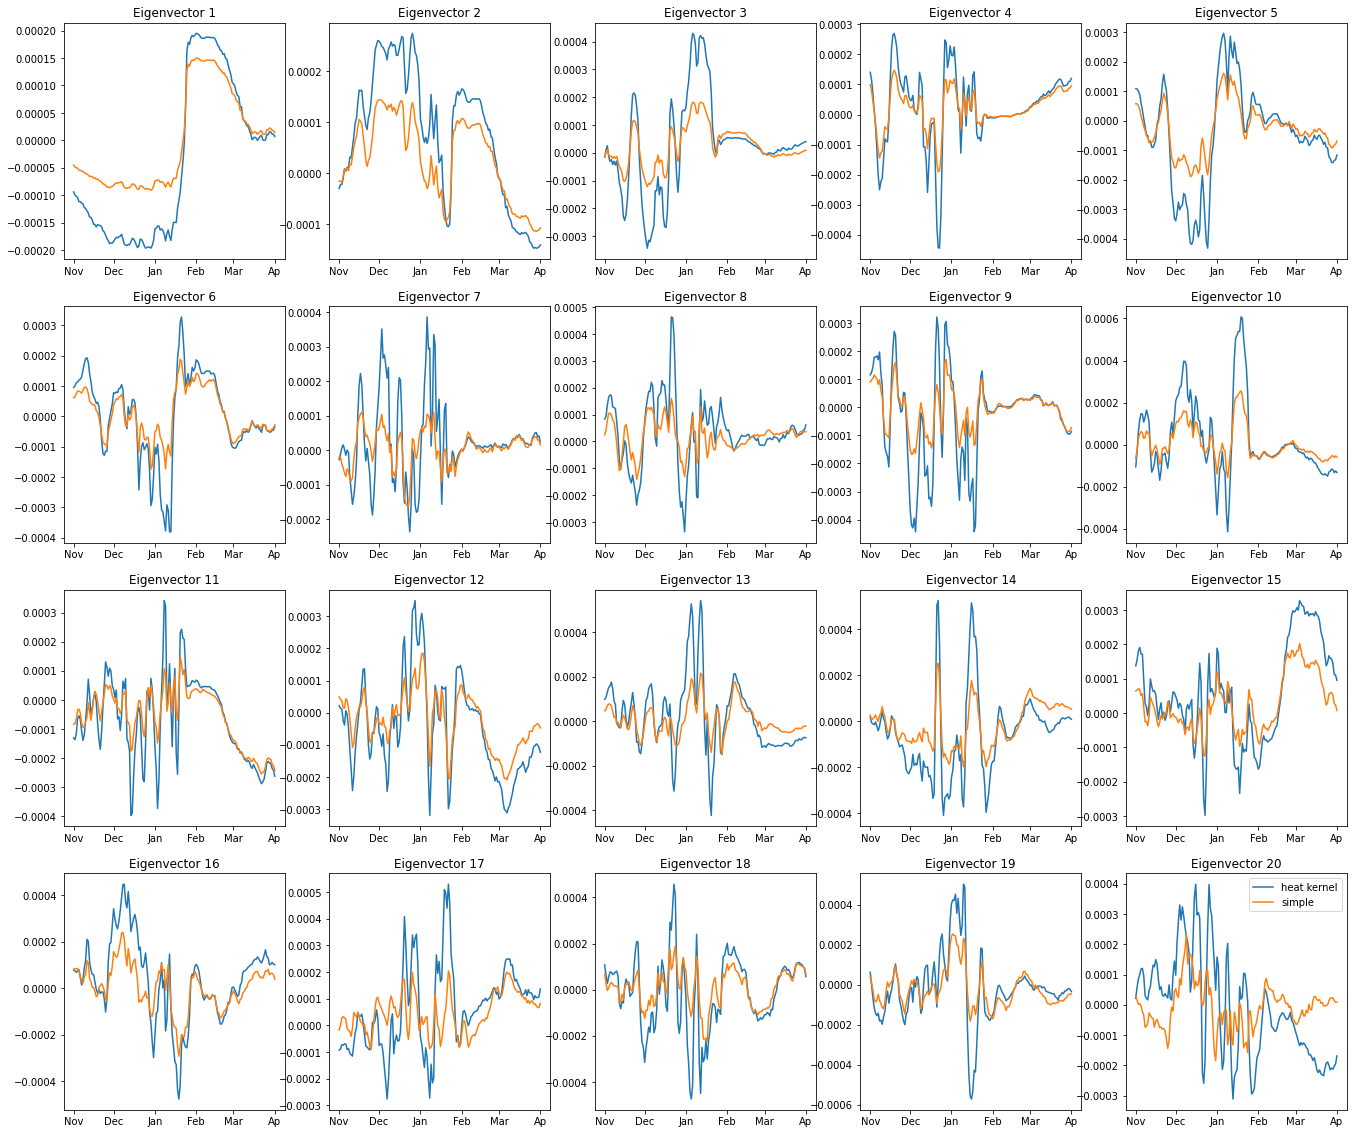

In [32]:
if DATA == 'raw':
    sign_mean = [0, 1, 1, -1, -1,1,1,1,1,1,1,1, 1, -1, -1,1,1,1,1,1,1]
    sign_simple = [0, 1, 1, -1, -1,-1,1,-1,1,1,1,1, 1, -1, -1,1,1,1,1,1,1]
else:
    sign_mean = [0, 1, 1, -1, -1,1,1,1,1,1,1,1, 1, -1, -1,1,1,1,1,1,1]
    sign_simple = [0, 1, 1, 1, -1,1,1,1,-1,1,1,1, 1, 1, 1,1,1,-1,1,-1,-1]
plot_one_winter(eigv_time_mean, eigv_time_simple, sign_mean, sign_simple)

In [33]:
def plot_one_winter_single(eigv_time, eigv_time_simple, eigv):
    fig, axs = plt.subplots(1, 1, figsize=(5, 3))
    winter_2008 = pd.date_range('2008-11', '2009-04')
    winter_2008_eig_mean = eigv_time[eigv][winter_2008]
    winter_2008_eig_simple = eigv_time_simple[eigv][winter_2008]

    axs.plot(winter_2008_eig_mean.index,
                               sign_mean[eigv] * winter_2008_eig_mean.values,
                               label='heat kernel')
    axs.plot(winter_2008_eig_simple.index,
                               sign_simple[eigv] * winter_2008_eig_simple.values,
                               label='simple')
    #axs.set_title(f"Eigenvector {eigv}")
    axs.set_xticklabels(['Nov', 'Dec', 'Jan', 'Feb', 'Mar', 'Ap'])
    plt.legend()

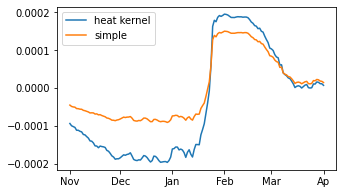

In [34]:
plot_one_winter_single(eigv_time_mean, eigv_time_simple, 1)

### Plot overlapping winters:

In [19]:
def transform_date(column):
    new_col = []
    year = column[0].year
    for i in column:
        month = i.month
        day = i.day
        if i.year > year:
            new_col.append(datetime(1984, month, day))
        else:
            new_col.append(datetime(1983, month, day))
    return new_col

In [55]:
def winters_supp(eigv_time, ax, eig, alpha=1.0, linewidth=2):
    years = eigv_time[eig].index.year.unique()
    n = len(years)
    colors = plt.cm.jet(np.linspace(0, 1, n))
    i = 1

    winter_eigs = []

    for year in years[:-1]:
        winter_of_that_year = pd.date_range(
            str(year) + '-11',
            str(year + 1) + '-04')
        winter_eig = eigv_time[eig][winter_of_that_year]
        winter_eig2 = eigv_time_simple[eig][winter_of_that_year]

        winter_eigs.append(winter_eig.values)
        ax.plot(transform_date(winter_eig.index),
                winter_eig.values,
                color='grey',
                alpha=alpha,
                linewidth=linewidth)
        ax.set_xticklabels(['Nov', 'Dec', 'Jan', 'Feb', 'Mar', 'Ap'])
        i += 1

    winter_of_that_year = pd.date_range(
        str(1979) + '-11',
        str(1979 + 1) + '-04')

    winter_eig = eigv_time[1][winter_of_that_year]

    df_winters = pd.DataFrame(winter_eigs).transpose()
    df_winters.index = transform_date(winter_eig.index)
    MEAN_WINTERS = df_winters.mean(axis=1)
    MEAN_WINTERS.index = transform_date(MEAN_WINTERS.index)
    MEDIAN_WINTERS = df_winters.median(axis=1)
    MEDIAN_WINTERS.index = transform_date(MEDIAN_WINTERS.index)

    ax.plot(MEAN_WINTERS,
            label='mean',
            color='r',
            alpha=alpha,
            linewidth=1.0)
    ax.plot(MEDIAN_WINTERS,
            label='median',
            color='b',
            alpha=alpha,
            linewidth=1.0)

    plt.legend(loc='upper left')

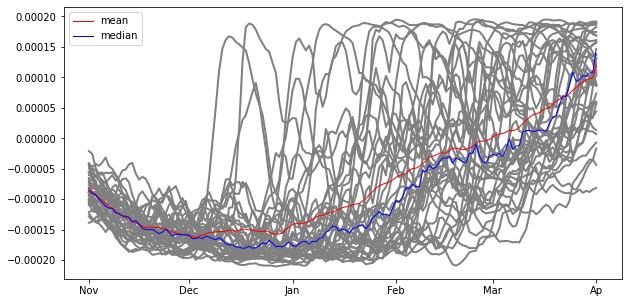

In [56]:
fig, ax = plt.subplots(1, figsize = (10,5))
winters_supp(eigv_time_mean, ax, 1)
#plt.title('Overlapping winters for the first eigenvector of Heat kernel')

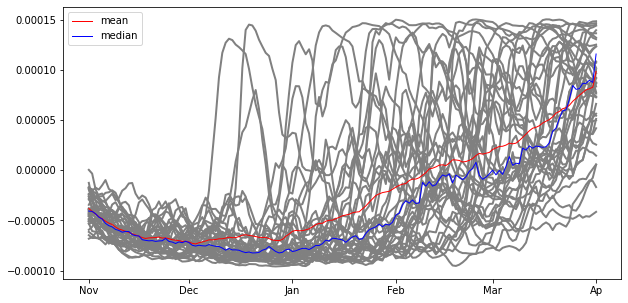

In [57]:
fig, ax = plt.subplots(1, figsize = (10,5))
winters_supp(eigv_time_simple, ax, 1)
#plt.title('Overlapping winters for the first eigenvector of Simple kernel')

In [39]:
def plot_few_years(eigv_time):
        years = [1979,1980,1981,1982,1983,1985]
        n = len(years)
        colors = plt.cm.jet(np.linspace(0,1,n))
        fig, ax = plt.subplots()
        i = 0
        for year in years[:-1]:
            winter_of_that_year = pd.date_range(str(year)+'-11',str(year+1)+'-04')
            winter_eig = eigv_time[1][winter_of_that_year]
            ax.plot(transform_date(winter_eig.index), winter_eig.values, label = year, color=colors[i])
            ax.set_xlabel('Winter 1979-1985')
            ax.set_title('Winters of the first eigenvector')
            ax.set_xticklabels(['Nov','Dec','Jan','Feb','Mar','Ap'])
            i+= 1
        plt.legend()
        plt.show()

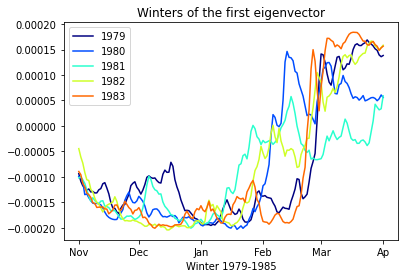

In [40]:
plot_few_years(eigv_time_mean)

### Multiplot: 

In [102]:
eig_1 = eigv_time_mean[1]
eig_2 = eigv_time_mean[2]
eig_3 = eigv_time_mean[3]
eig_4 = eigv_time_mean[4]
eig_5 = eigv_time_mean[5]

In [106]:
PATH1

'../../../data/vandermeer/pickles/raw/10perc/'

In [107]:
winter_2008 = pd.date_range('2008-11', '2009-04')

if DATA == 'raw':
    np.save(PATH1+'t_mean/eignpy_1.npy', eig_1)
    np.save(PATH1+'t_mean/eignpy_2.npy',eig_2)
    np.save(PATH1+'t_mean/eignpy_3.npy', eig_3)
    np.save(PATH1+'t_mean/eignpy_4.npy',eig_4)
    np.save(PATH1+'t_mean/eignpy_5.npy',eig_5)
    np.save(PATH1+'t_mean/winter_eignpy_1.npy', eig_1[winter_2008])
    np.save(PATH1+'t_mean/winter_eignpy_2.npy',eig_2[winter_2008])
    np.save(PATH1+'t_mean/winter_eignpy_3.npy', eig_3[winter_2008])
    np.save(PATH1+'t_mean/winter_eignpy_4.npy',eig_4[winter_2008])
    np.save(PATH1+'t_mean/winter_eignpy_5.npy',eig_5[winter_2008])
else:
    np.save(PATH1+'t_mean/eignpy_an_1.npy', eig_1)
    np.save(PATH1+'t_mean/eignpy_an_2.npy',eig_2)
    np.save(PATH1+'t_mean/eignpy_an_3.npy', eig_3)
    np.save(PATH1+'t_mean/eignpy_an_4.npy',eig_4)
    np.save(PATH1+'t_mean/eignpy_an_5.npy',eig_5)

In [108]:
! ls ../../../data/vandermeer/pickles/raw/10perc/t_mean

Eig1_mean_part1.npy  X_prime_9.npy
X_prime_0.npy	     diagonal_heat_matrix_t_mean_.pkl
X_prime_1.npy	     eig1_mean_part1.npy
X_prime_10.npy	     eig1_mean_part2.npy
X_prime_11.npy	     eig1_mean_part3.npy
X_prime_12.npy	     eigenvalues_heat_matrix_t_mean_.pkl
X_prime_13.npy	     eigenvectors_heat_matrix_t_mean_.pkl
X_prime_14.npy	     eignpy_1.npy
X_prime_15.npy	     eignpy_2.npy
X_prime_16.npy	     eignpy_3.npy
X_prime_17.npy	     eignpy_4.npy
X_prime_18.npy	     eignpy_5.npy
X_prime_19.npy	     heat_matrix_t_mean_.pkl
X_prime_2.npy	     laplacian_heat_matrix_t_mean_.pkl
X_prime_3.npy	     winter_eignpy_1.npy
X_prime_4.npy	     winter_eignpy_2.npy
X_prime_5.npy	     winter_eignpy_3.npy
X_prime_6.npy	     winter_eignpy_4.npy
X_prime_7.npy	     winter_eignpy_5.npy
X_prime_8.npy


In [84]:
import matplotlib.collections as mcoll
import matplotlib.path as mpath

def colorline(
    x, y, ax,z=None, cmap=plt.get_cmap('copper'), norm=plt.Normalize(0.0, 1.0),
        linewidth=3, alpha=1.0):
    """
    http://nbviewer.ipython.org/github/dpsanders/matplotlib-examples/blob/master/colorline.ipynb
    http://matplotlib.org/examples/pylab_examples/multicolored_line.html
    Plot a colored line with coordinates x and y
    Optionally specify colors in the array z
    Optionally specify a colormap, a norm function and a line width
    """

    # Default colors equally spaced on [0,1]:
    if z is None:
        z = np.linspace(0.0, 1.0, len(x))

    # Special case if a single number:
    if not hasattr(z, "__iter__"):  # to check for numerical input -- this is a hack
        z = np.array([z])

    z = np.asarray(z)

    segments = make_segments(x, y)
    lc = mcoll.LineCollection(segments, array=z, cmap=cmap, norm=norm,
                              linewidth=linewidth, alpha=alpha)

    #ax = plt.gca()
    ax.add_collection(lc)

    return lc


def make_segments(x, y):
    """
    Create list of line segments from x and y coordinates, in the correct format
    for LineCollection: an array of the form numlines x (points per line) x 2 (x
    and y) array
    """
    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    return segments

In [85]:
i = 0
j = 0
plots = [[0], [eig_1, eig_2], [eig_1, eig_3], [eig_1, eig_4],
         [eig_1, eig_5],[eig_2, eig_1], [0], [eig_2, eig_3], [eig_2, eig_4],
         [eig_2, eig_5], [eig_3, eig_1], [eig_3, eig_2], [0], [eig_3, eig_4],
         [eig_3, eig_5], [eig_4, eig_1], [eig_4, eig_2], [eig_4, eig_3], [0],
         [eig_4, eig_5], [eig_5, eig_1], [eig_5, eig_2], [eig_5, eig_3],
         [eig_5, eig_4], [0]]

def multiplot(eigv_time, plots):
    fig, axs = plt.subplots(5, 5, figsize=(20, 20))
    m = 0
    for i in range(5):
        for j in range(5):
            pl = plots[m]
            if i != j:
                axs[i, j].plot(pl[0], pl[1], alpha = 0.8, color = 'grey',linewidth=0.15)
                
                winter_2008 = pd.date_range('2008-11', '2009-04')
                winter_2008_eig_0 = pl[0][winter_2008]
                winter_2008_eig_1 = pl[1][winter_2008]
                colorline(winter_2008_eig_0, winter_2008_eig_1, axs[i, j],cmap=plt.get_cmap('winter_r'), linewidth=2)
                axs[i, j].locator_params(axis='x', nbins=3)

            else:
                winters_supp(eigv_time, axs[i, j], i + 1, alpha = 0.8,linewidth=0.5)
            if i == 0:
                axs[i,j].set_title(j+1)
            if j == 0:
                axs[i,j].set_ylabel(i+1)
            m += 1
    plt.show()   

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


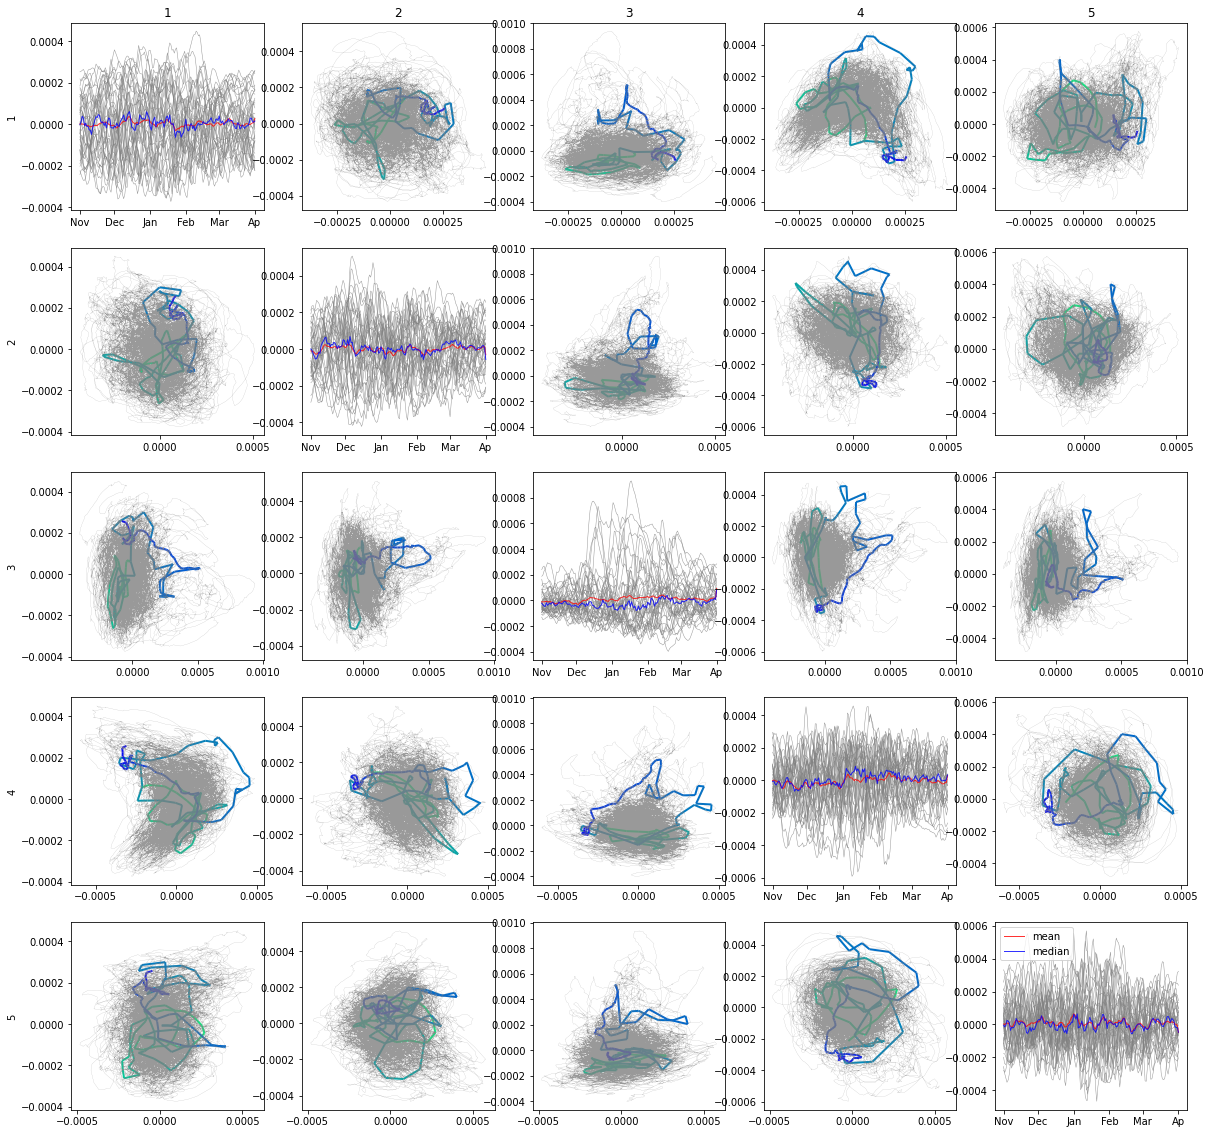

In [86]:
multiplot(eigv_time_mean, plots);

shows that there is some structure, can’t say what without doing the spacial reconstruction, here have nonlinear dependance
look at spatial pattern of third eigenvector of anomalies, circles capture some rotation 
try to understand the states of the vortex and is there a clear classification between those states
read up on lores attractor, represent climatical systems with 3d summaries looking like some buterlfly
taking 1 versus 2 we can define three regions, select times which correspond to theses regions and taking these samples in the original space we compute means if these samples and plot in original space —> give average pattern which corresponds to data
pattern 2 versus 5 looks best to define about three regions

for anomalies, can take just average in quadrants of outer regions for the same kind of plot

for diagonal of anomalies, take threshold and take time steps above threshold and look at what average of those look like

tau  = 1 month (30 days) 

### Power Spectrums:
Power spectrum plot for all years and then see something every 7 months

In [80]:
sampling_rate_seconds = 4 / (24 * 3600)
print(f'Frequency: {sampling_rate_seconds} [s-1]')
sampling_rate_days = 4
print(f'Frequency: {sampling_rate_days} [d-1]')
sampling_time = 1 / sampling_rate_days
print(f'Sampling every  {sampling_time*24} hours')
year_t = 365
two_year_t = (365 / 2)
three_year_t = (365 / 3)
freq_year = 1 / year_t
freq_two_year = 1 / two_year_t
freq_three_year = 1 / three_year_t

Frequency: 4.6296296296296294e-05 [s-1]
Frequency: 4 [d-1]
Sampling every  6.0 hours


Pperations on frequency : log(frequency) -> in time 1/frequency
indicate the 1/year, 2/year and 3/year frequencie

Estimate power spectral density using a periodogram. Change to 1/frequency to time.

In [81]:
"""
Power spectrum with zero padding for the missing dates:
"""
def pwr_compl(eigv_time, sampling_rate_days, number, axs):
    full_time = pd.date_range(start='1/1/1979', end='1/1/2019', freq='6H')
    full_df = pd.DataFrame(np.zeros((len(full_time), 20)))
    full_df.index = full_time
    full_df.columns = [str(i) for i in eigv_time.columns]
    eigv_time.columns = [str(i) for i in eigv_time.columns]

    cols_to_use = full_df.transpose().columns.difference(
        eigv_time.transpose().columns)
    full_df_time = pd.merge(left=full_df.transpose()[cols_to_use],
                            right=eigv_time.transpose(),
                            how='right',
                            left_index=True,
                            right_index=True,
                            suffixes='_x').transpose()
    full_df_time = full_df_time.sort_index()
    f, Pxx_den = signal.periodogram(full_df_time[str(number)], sampling_rate_days)
    axs.semilogy(np.log(1 / f), Pxx_den)
    axs.axvline(np.log(year_t), color='r', linestyle=':', label='Every year')
    axs.axvline(np.log(two_year_t),
                color='g',
                linestyle=':',
                label='Twice per year')
    axs.axvline(np.log(three_year_t),
                color='orange',
                linestyle=':',
                label='Thrice per year')
    #axs.set_title("Powerspectrum of first eigenvector of Heat kernel")
    axs.set_xticklabels(['0', '1', '7', '54', '403', '2980'])
    axs.set_xlabel('Days')
    #axs.set_ylabel('log(time [d])')

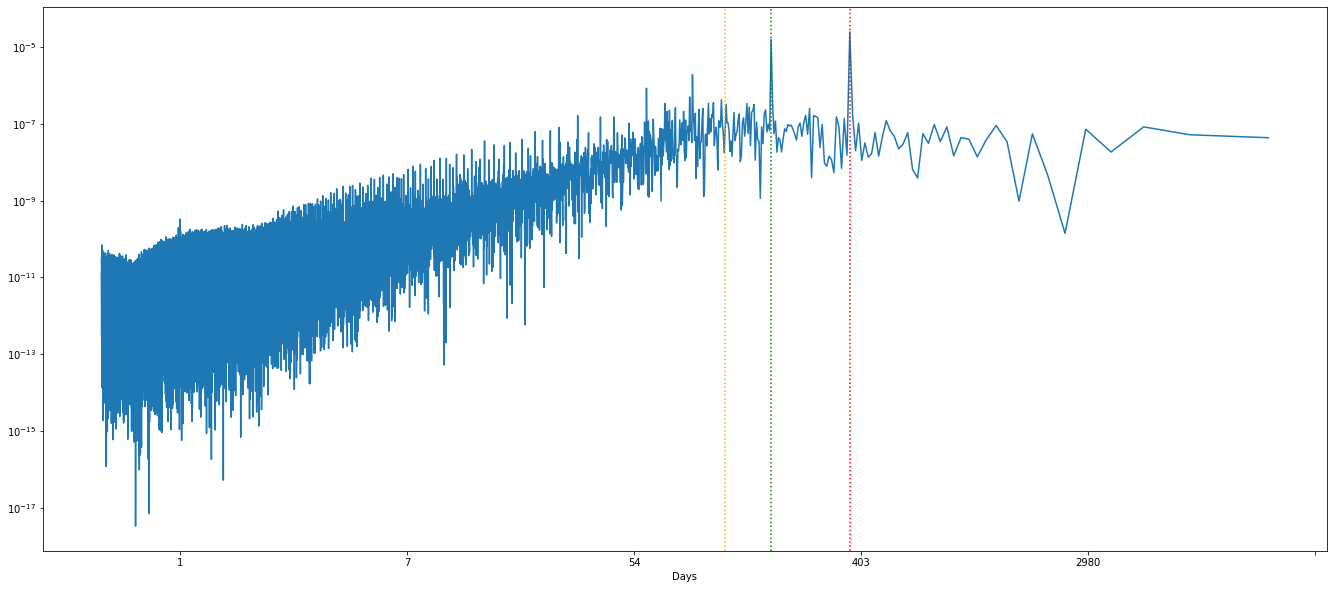

In [82]:
fig, axs = plt.subplots(1, figsize=(23, 10))
pwr_compl(eigv_time_mean, sampling_rate_days,1,axs)

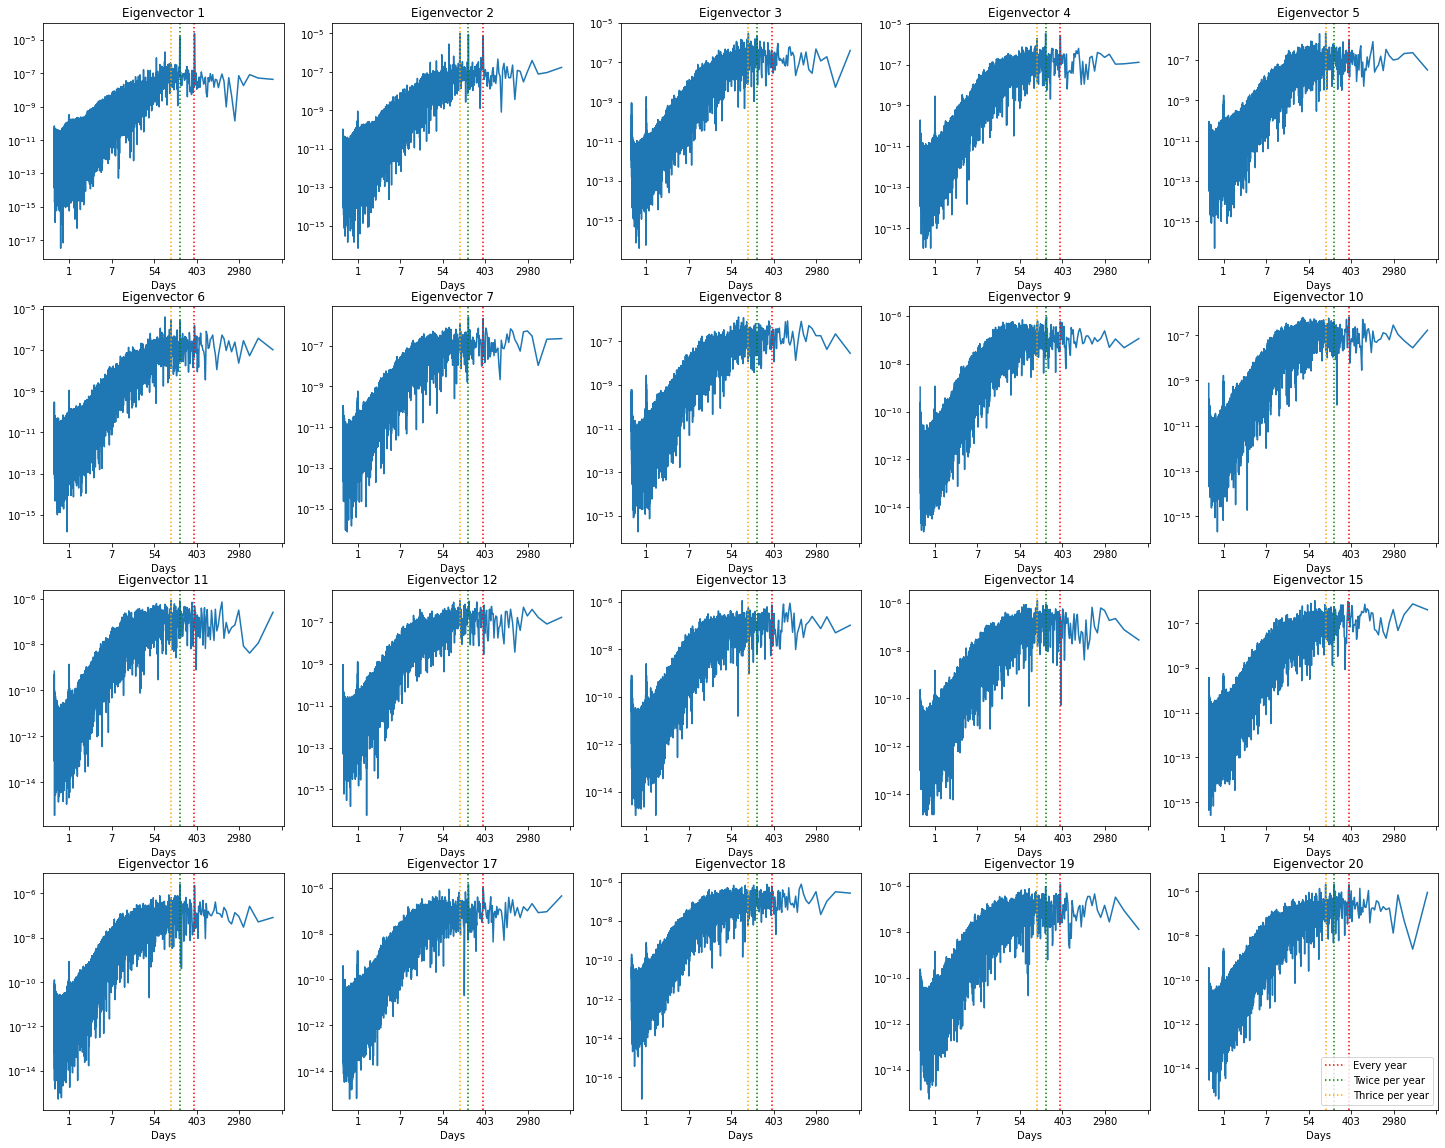

In [83]:
fig, axs = plt.subplots(4, 5, figsize=(25, 20))
m = 1
for i in range(4):
    for j in range(5):
        pwr_compl(eigv_time_mean, sampling_rate_days, m, axs[i,j])
        axs[i,j].set_title(f'Eigenvector {m}')
        m+= 1
plt.legend()

### Projection on geographical data: 
Perform projection $X'\in R^{1001x1}= X^T D \phi_i$. $X'_i = X \phi_i \phi_i^T, \phi \in R^{33960}, X \in R^{Nx1001}$ 

In [24]:
%%time
if DATA == 'anomalies':
    print(f'Reading {DATA} data from {INPUT_DATA}')
    df = pd.read_csv(INPUT_DATA + 'anomalies_coefficients.csv', sep=',')
    print(f'Reading eigenvectors from {PATH1}')
    eigv = pd.read_pickle(PATH1+'t_mean/eigenvectors_heat_matrix_t_mean_.pkl').values
    eigv = pd.DataFrame(eigv).drop([0], axis = 1).values

else:
    print(f'Reading {DATA} data from {INPUT_DATA}')
    df = pd.read_csv(INPUT_DATA + 'raw_data_coefficients.csv', sep=',')
    print(f'Reading eigenvectors from {PATH1}')
    eigv = pd.read_pickle(PATH1+'t_mean/eigenvectors_heat_matrix_t_mean_.pkl').values
    eigv = pd.DataFrame(eigv).drop([1], axis = 1).values

Xt = df.drop(['Unnamed: 0','Date'], axis = 1).values.transpose()
print(f'Reading diagonal matrix from {PATH1}')
D = pd.read_pickle(PATH1+'t_mean/diagonal_heat_matrix_t_mean_.pkl').values

print(f'Xt shape: {Xt.shape}')
print(f'Diagonal matrix shape: {D.shape}')
print(f'Eigenvectors shape: {eigv.shape}')

Reading anomalies data from ../../../data/vandermeer/input_data/
Reading eigenvectors from ../../../data/vandermeer/pickles/anomalies/10perc/
Reading diagonal matrix from ../../../data/vandermeer/pickles/anomalies/10perc/
Xt shape: (1001, 33960)
Diagonal matrix shape: (33960, 33960)
Eigenvectors shape: (33960, 20)
CPU times: user 7.17 s, sys: 8.68 s, total: 15.9 s
Wall time: 15.8 s


Projections on eigenvectors:

In [25]:
eigv.shape

(33960, 20)

In [26]:
for i in range(NUM_EIGENVALUES-1):
    X_prime_i = Xt @ D @  eigv[:,i]
    np.save(PATH1 +'t_mean/'+ 'X_prime_{}.npy'.format(i), X_prime_i)
    print('Saving X_prime_{}.npy at {}'.format(i, PATH1+'t_mean/'))
del Xt, D, eigv

Saving X_prime_0.npy at ../../../data/vandermeer/pickles/anomalies/10perc/t_mean/
Saving X_prime_1.npy at ../../../data/vandermeer/pickles/anomalies/10perc/t_mean/
Saving X_prime_2.npy at ../../../data/vandermeer/pickles/anomalies/10perc/t_mean/
Saving X_prime_3.npy at ../../../data/vandermeer/pickles/anomalies/10perc/t_mean/
Saving X_prime_4.npy at ../../../data/vandermeer/pickles/anomalies/10perc/t_mean/
Saving X_prime_5.npy at ../../../data/vandermeer/pickles/anomalies/10perc/t_mean/
Saving X_prime_6.npy at ../../../data/vandermeer/pickles/anomalies/10perc/t_mean/
Saving X_prime_7.npy at ../../../data/vandermeer/pickles/anomalies/10perc/t_mean/
Saving X_prime_8.npy at ../../../data/vandermeer/pickles/anomalies/10perc/t_mean/
Saving X_prime_9.npy at ../../../data/vandermeer/pickles/anomalies/10perc/t_mean/
Saving X_prime_10.npy at ../../../data/vandermeer/pickles/anomalies/10perc/t_mean/
Saving X_prime_11.npy at ../../../data/vandermeer/pickles/anomalies/10perc/t_mean/
Saving X_prime

### Comments: 
- First request a lot of eigenvectors and check that only one eigenvector that has eigenvalue close to zero (~$10^{-15}$) and might need to increase number of neighbours otherwise (check if graph is connected): **DONE FOR 50 EIGENVALUES, ONLY ONE ZERO**
- Take the mean over all winters : **DONE**
- Change to heat kernel and compute for different kernel values, and more than 10 eigenvectors. Plot also the eigenvalues. **DONE**
- To choose t: look at distances and take mean or max of all distances among neighbours. Check if t is not the squared of distance. For large t we should have something close to what we have now. 
- Move to anomaly data
- Power spectrum with missing data ? Compute power spectrum for other eigenvectors. So up to 7 months alright and then a gap and the rest should start at 360 and multiply by $365/(7x30)$ **DONE**

- anomaly data estimated seasonality from raw data. estimate smooth mean and remove it to obtain the anomaly. 
- switch from default weight to gaussian kernel, optimise bandwidth computational demanding, try multiple experiments, assess the best bandwidth also define what best means
- apply also to anomaly data to see if consistent
- include to the model so that it can capture the dynamics of system, those things are called backends embedding (use multiple time steps to represent one sample -> sequences) —> apply and optimite previous all to new representation of data 

Pic raw data so that the first mode of variability should be the seasonality 
capturing something, huge variability but don’t know what

gaussian kernel approximates distance on manifold using this laplacian graph. The 0-1 weights is not very realistic because two samples that might be similar they might be different, For now they all have the sae weight. Not very good to approximate distances. For bandwidth t goes to 0 and a lot of data, converge to the distance on the manifold. 
